<a href="https://colab.research.google.com/github/ftrova1/Dataset_TEM/blob/master/TEM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
!ls '/content/drive/My Drive/Coding/Projects/TEM'

test  train


In [0]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.optimizers import adam
from keras import backend as K

## Seeding 
seed = 2020
random.seed = seed
np.random.seed = seed
tf.seed = seed

Using TensorFlow backend.


(1024, 1024, 3)
[ 85 170 255]


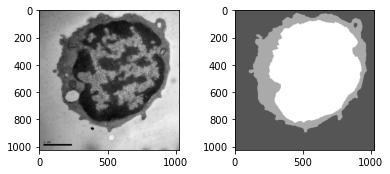

In [0]:
img = cv2.imread('/content/drive/My Drive/Coding/Projects/TEM/train/10_B1_19000x/data/10_B1_19000x.tif')
mask = cv2.imread('/content/drive/My Drive/Coding/Projects/TEM/train/10_B1_19000x/masks/10_B1_19000x.tif_segmentation.tifnormalized.tif')
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask)
#print (np.unique(mask))
#print(np.unique(mask), mask.shape, img.shape)
#mask = mask / 255

print (mask.shape)
print (np.unique(mask))

#mask_cat = tf.keras.utils.to_categorical(mask,3)
#print (mask_cat[:,:,0])

In [0]:
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item
        
def sort_deduplicate(l):
    return uniq(sorted(l, reverse=True))

lista = []
for i in range(1024):
    for j in range(1024):
        lista.append(mask[i,j,:].tolist())

palette_gen = sort_deduplicate(lista)
palette = []
for item in palette_gen:
    palette.append(item)
    
palette

[[255, 255, 255], [170, 170, 170], [85, 85, 85]]

In [0]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, masks_dict, batch_size=8, image_size=256, data_path = 'data', masks_path = 'masks'):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.masks_dict = masks_dict
        self.on_epoch_end()
        
    def __load__(self, id_name):
        image_path = os.path.join(self.path, id_name, "data", id_name) + '.tif'
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = image/255.0
        mask = self.masks_dict[id_name]

        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [0]:
image_size = 256
train_path = "/content/drive/My Drive/Coding/Projects/TEM/train/"
validation_path = "/content/drive/My Drive/Coding/Projects/TEM/test/"
epochs = 400
batch_size = 4

## Training Ids
train_ids = next(os.walk(train_path))[1]
#print(train_ids)

train_masks_dict = {}    
test_masks_dict = {} 

## Validation Ids
valid_ids = next(os.walk(validation_path))[1]

valid_ids = valid_ids[:]
train_ids = train_ids[:]

for train_id in train_ids:
    mask_path = os.path.join(train_path, train_id, "masks/")

    _mask_path = mask_path + train_id + '.tif_segmentation.tifnormalized.tif'
    _mask_image = cv2.imread(_mask_path)
    _mask_image = cv2.resize(_mask_image, (image_size, image_size)) 
    mask = _mask_image

    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all (tf.equal(mask,colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis = -1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    
    train_masks_dict[train_id] = np.asarray(one_hot_map)
    #cv2.imwrite('/content/drive/My Drive/Coding/Projects/TEM/prova_maschera.png', np.float32(one_hot_map))
    #break
    

for test_id in valid_ids:
    mask_path = os.path.join(validation_path, test_id, "masks/")

    _mask_path = mask_path + test_id + '.tif_segmentation.tifnormalized.tif'
    _mask_image = cv2.imread(_mask_path)
    _mask_image = cv2.resize(_mask_image, (image_size, image_size)) 
    mask = _mask_image

    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all (tf.equal(mask,colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis = -1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    
    test_masks_dict[test_id] = np.asarray(one_hot_map)
    #break

print (len(train_masks_dict),len(test_masks_dict))


454 193


(256, 256, 3)
(256, 256, 3)


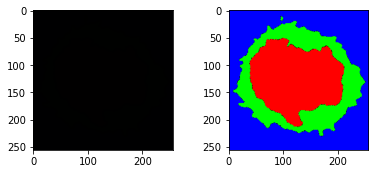

In [0]:
img2 = cv2.imread("/content/drive/My Drive/Coding/Projects/TEM/prova_maschera.png")
print (img2.shape)
img3 = train_masks_dict['100_C1_19000x']
print (img3.shape)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img2)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(img3)

plt.imsave('/content/drive/My Drive/Coding/Projects/TEM/prova_maschera2.png', np.asarray(img3))

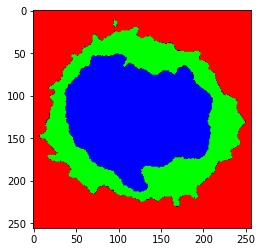

In [0]:
img4 = cv2.imread('/content/drive/My Drive/Coding/Projects/TEM/prova_maschera2.png')
plt.imshow(img4)

In [0]:
gen = DataGen(train_ids, train_path, train_masks_dict ,batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(4, 256, 256, 3) (4, 256, 256, 3)


(4, 256, 256, 3) (4, 256, 256, 3)


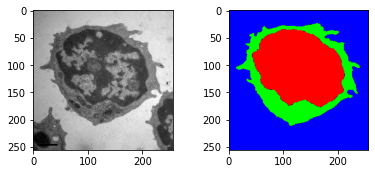

In [0]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y[r])
print(x.shape, y.shape)

In [0]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [0]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="softmax")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true*y_pred ), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

model = UNet()
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [0]:
train_gen = DataGen(train_ids, train_path, train_masks_dict, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, validation_path, test_masks_dict, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model_checkpoint = ModelCheckpoint('unet_tem.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(train_gen, validation_data=valid_gen, validation_steps=valid_steps, 
                    epochs=epochs, callbacks=[model_checkpoint])
#model.load_weights('unet_tem.hdf5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 114 steps, validate for 48 steps
Epoch 1/400
111/114 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9400
Epoch 00001: loss improved from inf to 0.13477, saving model to unet_tem.hdf5
114/114 [==============================] - 6s 52ms/step - loss: 0.1361 - accuracy: 0.9399 - val_loss: 0.1801 - val_accuracy: 0.9229
Epoch 2/400
111/114 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9347
Epoch 00002: loss did not improve from 0.13477
114/114 [==============================] - 3s 28ms/step - loss: 0.1469 - accuracy: 0.9344 - val_loss: 0.1848 - val_accuracy: 0.9279
Epoch 3/400
112/114 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9403
Epoch 00003: loss did not improve from 0.13477
114/114 [==============================] - 3s 29ms/step - loss: 0.1414 - accuracy: 0.9402 - val_loss: 0.1568 - val_accuracy: 0.9345
Epoch 4/400
113/114 [===========================

In [0]:
x, y = valid_gen.__getitem__(4)
result = model.predict(x)

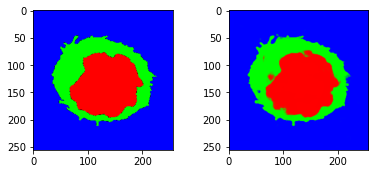

In [0]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(y[0])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(result[0])